In [204]:
import networkx as nx
import matplotlib.pyplot as plt
import metis
import numpy as np
import random
from sklearn.cluster import SpectralClustering
from random import choices, choice
from scipy import stats

#Annoying errors
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

***

### GENERATING GRAPHS

#### I. Synthetic graphs

#### SBM

In [99]:
sizes = [120, 120]
p = [[0.075, 0.01], [0.01, 0.075]]
G_SBM = nx.stochastic_block_model(sizes, p)

if not nx.is_connected(G_SBM):
    print("check")

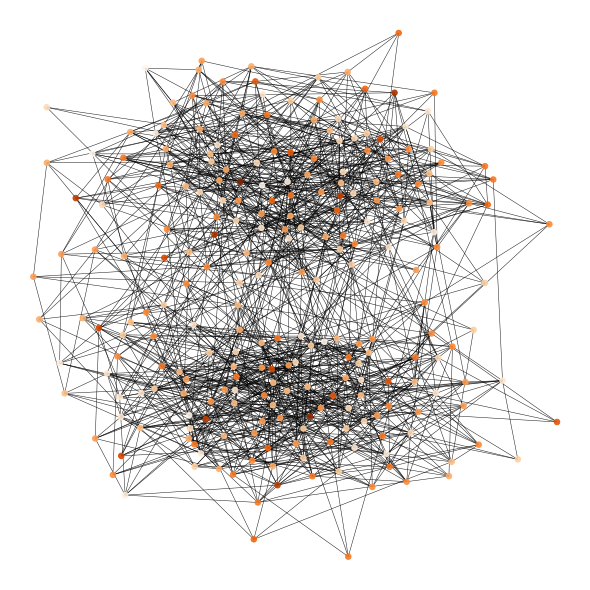

In [100]:
plt.figure(1, figsize=[8,8])
nx.draw(G_SBM, node_size=30, width=0.5, alpha=0.9, node_color = [v for k,v in G_SBM.degree()], cmap=plt.cm.Oranges)

#### Random Graphs

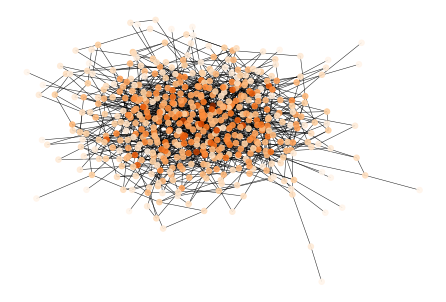

In [115]:
n = 500
p = 0.01
G_ER = nx.fast_gnp_random_graph(n, p)

if not nx.is_connected(G_ER):
    print("check")
    
nx.draw(G_ER, node_size=30, width=0.5, alpha=0.9, node_color = [v for k,v in G_ER.degree()], cmap=plt.cm.Oranges)

#### Tree

#### Barabasi-Albert 

In [116]:
n = 1000
m = 1

G_BA = nx.barabasi_albert_graph(n, m, seed=None)

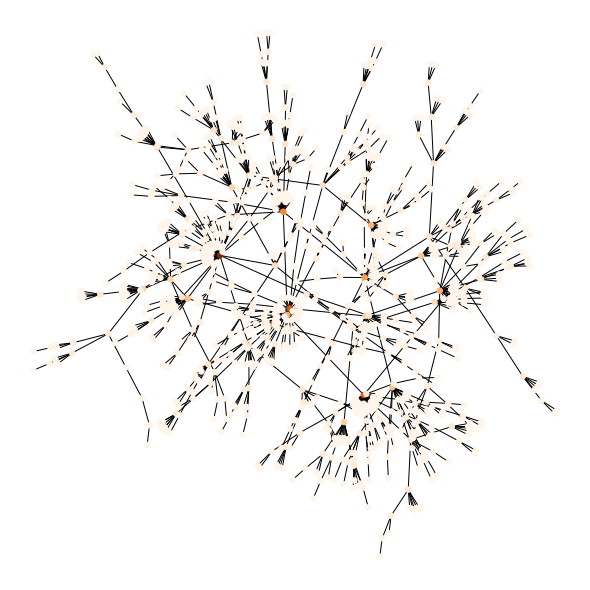

In [118]:
plt.figure(1, figsize=[8,8])
nx.draw(G_BA, node_size=30, node_color = [v for k,v in G_BA.degree()], cmap=plt.cm.Oranges)

#### II. Real networks

***

### GRAPH PARTITITON

#### Metis

In [3]:
def partition_metis(G):
    
    objval, parts = metis.part_graph(G, nparts=2)
    node_membership = dict(zip(G.nodes, parts))
    
    return node_membership

#### Spectral

In [4]:
def partition_spectral(G):
    
    adj_mat = nx.to_numpy_matrix(G)
    sc = SpectralClustering(2, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)
    node_membership = dict(zip(G.nodes, sc.labels_))
    
    return node_membership

#### Girvan-Newman

In [5]:
def partition_girvannewman(G):
    
    comp = nx.community.girvan_newman(G)
    c1, _ = tuple(sorted(c) for c in next(comp))
    node_membership = dict()
    
    for node in G.nodes:
        if node in c1:
            node_membership[node] = 0
        else:
            node_membership[node] = 1

    return node_membership

#### Bipartition

In [6]:
def partition_kerninghanlin(G):
    
    c1, _ = nx.community.kernighan_lin_bisection(G)
    node_membership = dict()
    
    for node in G.nodes:
        if node in c1:
            node_membership[node] = 0
        else:
            node_membership[node] = 1

    return node_membership

#### Greedy modularity maximization

In [7]:
def partition_clausetnewman(G):
    
    c = list(nx.community.greedy_modularity_communities(G))
    sorted_list = sorted(c, key=len, reverse=True)
    c1, c2 = sorted_list[0], sorted_list[1]

    node_membership = dict()

    for node in G.nodes:
        if node in c1:
            node_membership[node] = 0
        elif node in c2:
            node_membership[node] = 1
        else:
            node_membership[node] = -1

    return node_membership

***

### GRAPH POLARIZATION

In [198]:
def get_influencers(G, k, left_nodes, right_nodes):
    
    dict_degree = {}
    for node in G.nodes():
        dict_degree[node] = G.degree(node)

    sorted_dict_degree = sorted(dict_degree.items(), key=lambda kv: kv[1], reverse=True)
    
    count_left, count_right = 0, 0
    left_influencers, right_influencers = [], []
  
    for node in sorted_dict_degree:

        if (node[0] in left_nodes):

            if (count_left < k):
                left_influencers.append(node[0])
                count_left += 1
                
        elif (node[0] in right_nodes):

            if (count_right < k):
                right_influencers.append(node[0])
                count_right += 1
                
        else:
            print("Error")
    return left_influencers, right_influencers

In [199]:
def performRandomWalk(G, starting_node, li, ri):

    # Bunch of constants
    found = 0
    end_side = 0
    
    which_random_starting_node = starting_node
    
    while (found != 1):
        
        neighbors = list(G.neighbors(which_random_starting_node))
        next_node = random.choice(neighbors)
        
        if (next_node in li):
            end_side = "left"
            found = 1
            
        elif (next_node in ri):
            end_side = "right"
            found = 1
            
        else:
            which_random_starting_node = next_node
        
    return end_side

In [200]:
def random_walk_pol(G, ms, k, n_iter):
    
    left_left = 0
    left_right = 0
    right_right = 0
    right_left = 0
    
    left_nodes = [k for k in ms if ms[k] == 0]
    right_nodes = [k for k in ms if ms[k] == 1]

    assert len(G.nodes) == len(left_nodes) + len(right_nodes), "Missing node"
    
    left_influencers, right_influencers = get_influencers(G, k, left_nodes, right_nodes)

    for _ in range(n_iter):

        starting_side = random.choice(["left", "right"])

        if starting_side == "left":
            which_random_starting_node = random.choice(left_nodes)

        else:
            which_random_starting_node = random.choice(right_nodes)

        end_side = performRandomWalk(G, which_random_starting_node, left_influencers, right_influencers)

        if (starting_side == "left") and (end_side ==  "left"):
            left_left += 1

        elif (starting_side == "left") and (end_side ==  "right"):
            left_right += 1

        elif (starting_side == "right") and (end_side ==  "right"):
            right_right += 1

        elif (starting_side == "right") and (end_side ==  "left"):
            right_left += 1

        else:
            print("Oops!")
        
    e1 = (left_left)/(left_left+right_left)
    e2 = (left_right)/(left_right+right_right)
    e3 = (right_left)/(left_left+right_left)
    e4 = (right_right)/(left_right+right_right)
    
    return(e1*e4 - e2*e3)

In [201]:
def betweenness_pol(G, ms, n_iter):
    # this should be faster than the original implementation
    # same idea without the KDE 
    
    #bottleneck
    dict_eb = nx.edge_betweenness_centrality(G)
    
    cut_edges = []
    rest_edges = []
    BCC_dist = []

    for e in G.edges:
        s, t = e

        if ms[s] != ms[t]:
            cut_edges += [e]
        else:
            rest_edges += [e]

    cut_ebc = [dict_eb[k] for k in dict_eb if k in cut_edges]
    rest_ebc = [dict_eb[k] for k in dict_eb if k in rest_edges]

    assert len(G.edges) == len(cut_ebc) + len(rest_ebc), "Missing edge"

    for _ in range(n_iter):
        cut_dist = random.choices(cut_ebc, k = 10000)
        rest_dist = random.choices(rest_ebc, k = 10000)

        kl_divergence = stats.entropy(cut_dist, rest_dist)
        BCC = 1-2.71828**(-kl_divergence)
        BCC_dist += [BCC]
        
    return BCC_dist

#### Edge Betweenness polarization

In [94]:
res = betweenness_pol(G, ms_metis, 1000)
np.mean(res)

0.0598353772443901

#### Random Walk polarization

In [95]:
res = [random_walk_pol(G, ms_metis, 8, 1000) for _ in range(1000)]
np.mean(res)

0.2907341630846812

***

### EVALUATION

In [138]:
# Select the partition method
ms_metis = partition_metis(G_SBM)
ms_spectral = partition_spectral(G_SBM)
ms_girvan = partition_girvannewman(G_SBM)
#ms_bipartition = partition_metis(G)
#ms_clauset = partition_clausetnewman(G)

# Save the results
cm_results_SBM = {"metis": ms_metis, "spectral": ms_spectral, "girvan": ms_girvan}

#### 1. The effect of community detection algorithm used on polarization scores

**SBM**

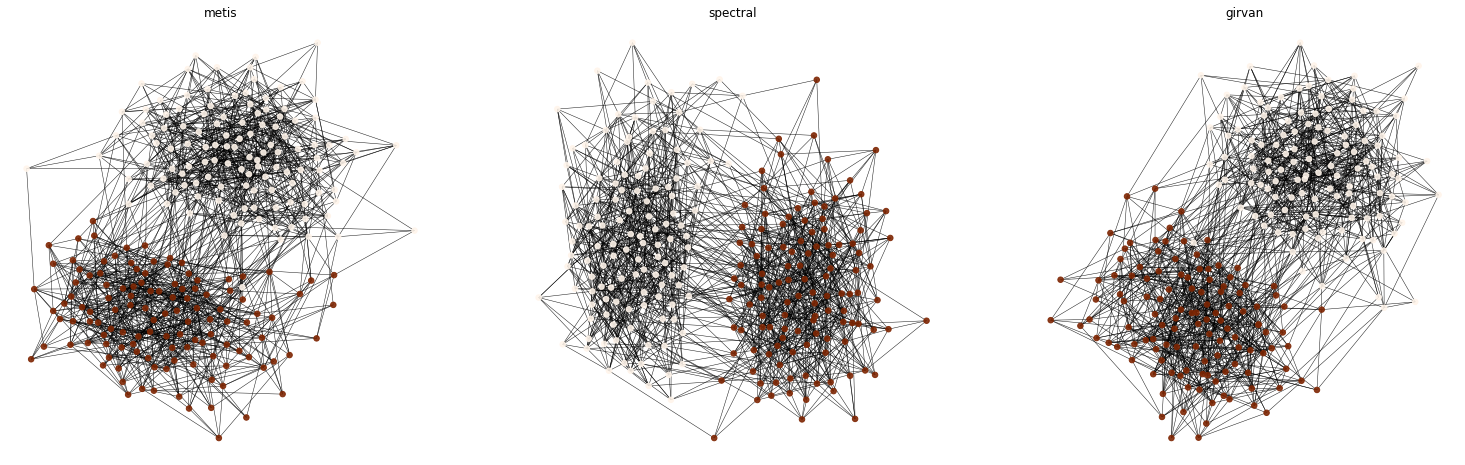

In [205]:
plt.figure(figsize=(26,8))

i = 1
for k in cm_results_SBM:
    plt.subplot(1,3,i)
    plt.title(k)
    nx.draw_spring(G_SBM, node_size=30, width=0.5, alpha=0.9, node_color = list(cm_results_SBM[k].values()), cmap=plt.cm.Oranges)
    i += 1

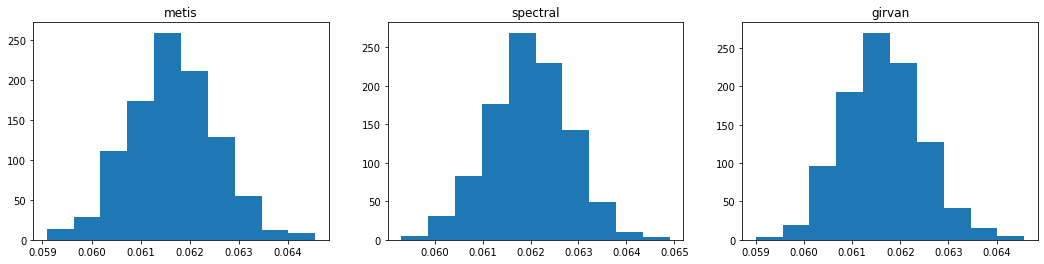

In [206]:
# EB
res_metis = betweenness_pol(G_SBM, cm_results_SBM["metis"], 1000)
res_spectral = betweenness_pol(G_SBM, cm_results_SBM["spectral"], 1000)
res_girvan = betweenness_pol(G_SBM, cm_results_SBM["girvan"], 1000)

res_all = {"metis": res_metis, "spectral": res_spectral, "girvan": res_girvan}

plt.figure(figsize=(18,4))

i = 1
for k in res_all:
    plt.subplot(1,3,i)
    plt.title(k)
    plt.hist(res_all[k])
    i += 1

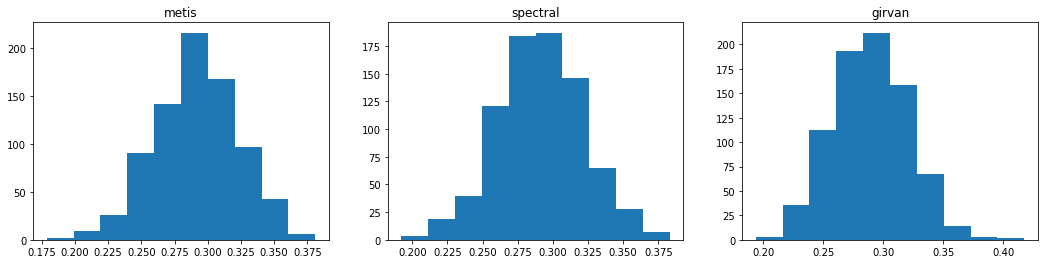

In [207]:
# RWC
res_metis = [random_walk_pol(G_SBM, cm_results_SBM["metis"], 6, 1000) for _ in range(800)]
res_spectral = [random_walk_pol(G_SBM, cm_results_SBM["spectral"], 6, 1000) for _ in range(800)]
res_girvan = [random_walk_pol(G_SBM, cm_results_SBM["girvan"], 6, 1000) for _ in range(800)]

res_all = {"metis": res_metis, "spectral": res_spectral, "girvan": res_girvan}

plt.figure(figsize=(18,4))

i = 1
for k in res_all:
    plt.subplot(1,3,i)
    plt.title(k)
    plt.hist(res_all[k])
    i += 1

**ER**

In [208]:
# Select the partition method
ms_metis = partition_metis(G_ER)
ms_spectral = partition_spectral(G_ER)
ms_girvan = partition_girvannewman(G_ER)

# Save the results
cm_results_ER = {"metis": ms_metis, "spectral": ms_spectral, "girvan": ms_girvan}

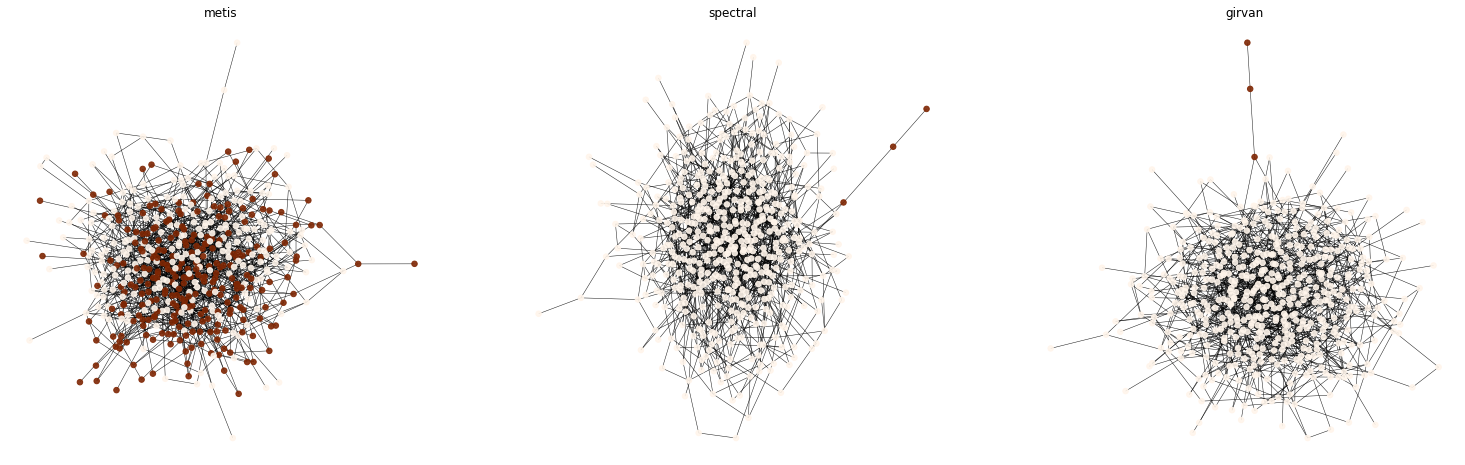

In [209]:
plt.figure(figsize=(26,8))

i = 1
for k in cm_results_ER:
    plt.subplot(1,3,i)
    plt.title(k)
    nx.draw_spring(G_ER, node_size=30, width=0.5, alpha=0.9, node_color = list(cm_results_ER[k].values()), cmap=plt.cm.Oranges)
    i += 1

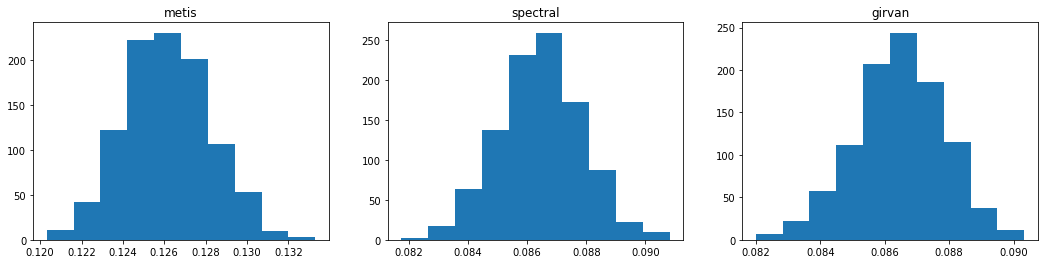

In [210]:
# EB
res_metis = betweenness_pol(G_SBM, cm_results_ER["metis"], 1000)
res_spectral = betweenness_pol(G_SBM, cm_results_ER["spectral"], 1000)
res_girvan = betweenness_pol(G_SBM, cm_results_ER["girvan"], 1000)

res_all = {"metis": res_metis, "spectral": res_spectral, "girvan": res_girvan}

plt.figure(figsize=(18,4))

i = 1
for k in res_all:
    plt.subplot(1,3,i)
    plt.title(k)
    plt.hist(res_all[k])
    i += 1

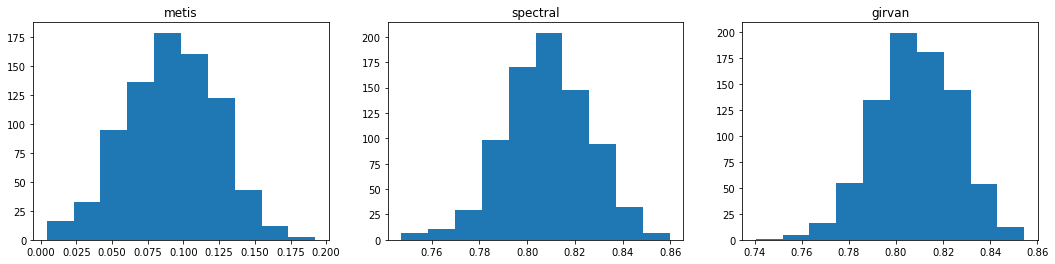

In [211]:
# RWC
res_metis = [random_walk_pol(G_ER, cm_results_ER["metis"], 6, 1000) for _ in range(800)]
res_spectral = [random_walk_pol(G_ER, cm_results_ER["spectral"], 6, 1000) for _ in range(800)]
res_girvan = [random_walk_pol(G_ER, cm_results_ER["girvan"], 6, 1000) for _ in range(800)]

res_all = {"metis": res_metis, "spectral": res_spectral, "girvan": res_girvan}

plt.figure(figsize=(18,4))

i = 1
for k in res_all:
    plt.subplot(1,3,i)
    plt.title(k)
    plt.hist(res_all[k])
    i += 1

**BA**

In [212]:
# Select the partition method
ms_metis = partition_metis(G_BA)
ms_spectral = partition_spectral(G_BA)
ms_girvan = partition_girvannewman(G_BA)

# Save the results
cm_results_BA = {"metis": ms_metis, "spectral": ms_spectral, "girvan": ms_girvan}

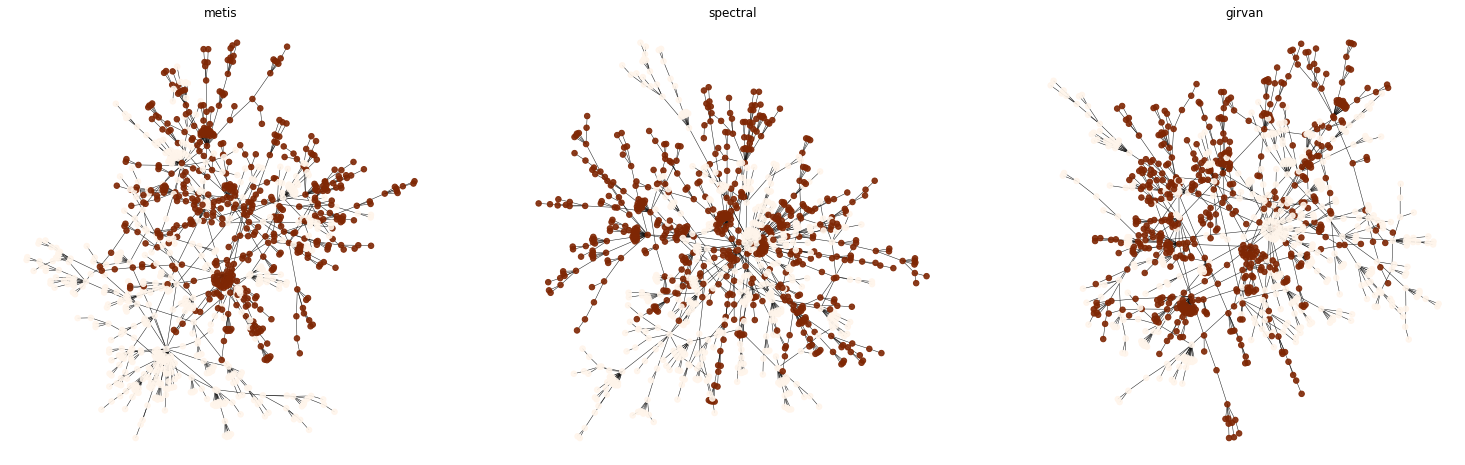

In [213]:
plt.figure(figsize=(26,8))

i = 1
for k in cm_results_BA:
    plt.subplot(1,3,i)
    plt.title(k)
    nx.draw_spring(G_BA, node_size=30, width=0.5, alpha=0.9, node_color = list(cm_results_BA[k].values()), cmap=plt.cm.Oranges)
    i += 1

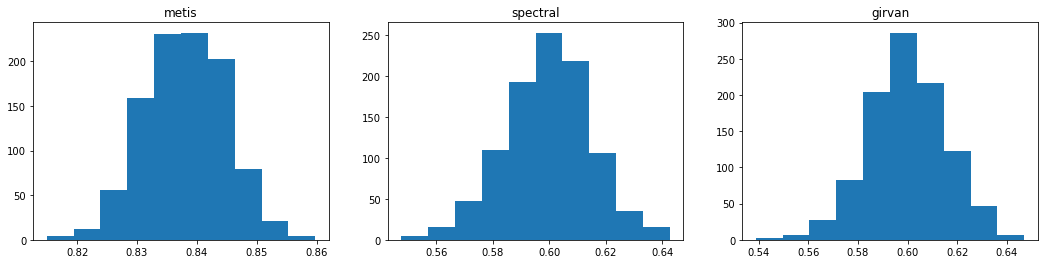

In [214]:
# EB
res_metis = betweenness_pol(G_BA, cm_results_BA["metis"], 1000)
res_spectral = betweenness_pol(G_BA, cm_results_BA["spectral"], 1000)
res_girvan = betweenness_pol(G_BA, cm_results_BA["girvan"], 1000)

res_all = {"metis": res_metis, "spectral": res_spectral, "girvan": res_girvan}

plt.figure(figsize=(18,4))

i = 1
for k in res_all:
    plt.subplot(1,3,i)
    plt.title(k)
    plt.hist(res_all[k])
    i += 1

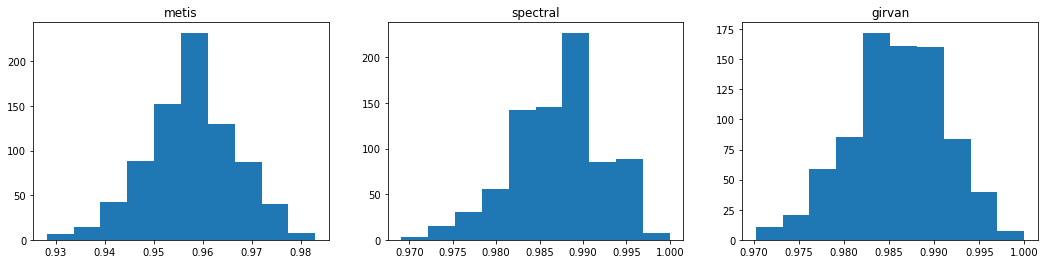

In [215]:
# RWC
res_metis = [random_walk_pol(G_BA, cm_results_BA["metis"], 6, 1000) for _ in range(800)]
res_spectral = [random_walk_pol(G_BA, cm_results_BA["spectral"], 6, 1000) for _ in range(800)]
res_girvan = [random_walk_pol(G_BA, cm_results_BA["girvan"], 6, 1000) for _ in range(800)]

res_all = {"metis": res_metis, "spectral": res_spectral, "girvan": res_girvan}

plt.figure(figsize=(18,4))

i = 1
for k in res_all:
    plt.subplot(1,3,i)
    plt.title(k)
    plt.hist(res_all[k])
    i += 1

#### 2. The effect of having unequal sized communities

#### 3. The effect of varying density

#### 4. The sensitivity analysis 